Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


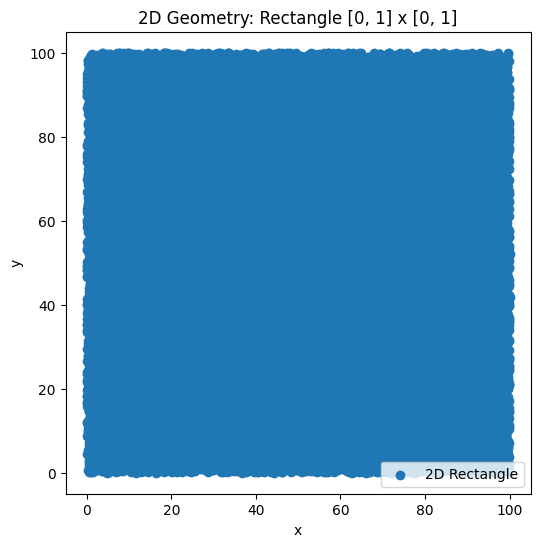

Compiling model...
'compile' took 0.880376 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [0.00e+00, 5.84e+13, 2.16e+00, 7.72e+00]    [0.00e+00, 5.84e+13, 2.16e+00, 7.72e+00]    []  
1000      [0.00e+00, 7.84e+10, 2.88e-06, 7.73e-06]    [0.00e+00, 7.84e+10, 2.88e-06, 7.73e-06]    []  
2000      [0.00e+00, 4.76e+10, 4.67e-05, 1.14e-04]    [0.00e+00, 4.76e+10, 4.67e-05, 1.14e-04]    []  
3000      [0.00e+00, 4.98e+10, 1.50e-06, 3.23e-06]    [0.00e+00, 4.98e+10, 1.50e-06, 3.23e-06]    []  
4000      [0.00e+00, 3.88e+09, 1.62e-07, 3.67e-08]    [0.00e+00, 3.88e+09, 1.62e-07, 3.67e-08]    []  
5000      [0.00e+00, 2.79e+09, 2.60e-07, 3.37e-07]    [0.00e+00, 2.79e+09, 2.60e-07, 3.37e-07]    []  
6000      [0.00e+00, 7.11e+08, 8.81e-07, 2.55e-06]    [0.00e+00, 7.11e+08, 8.81e-07, 2.55e-06]    []  
7000      [0.00e+00, 1.34e+08, 6.03e-07, 1.74e-06]    [0.00e+00, 1.34e+08, 6.03e-07, 1.74e-06]    []  
8

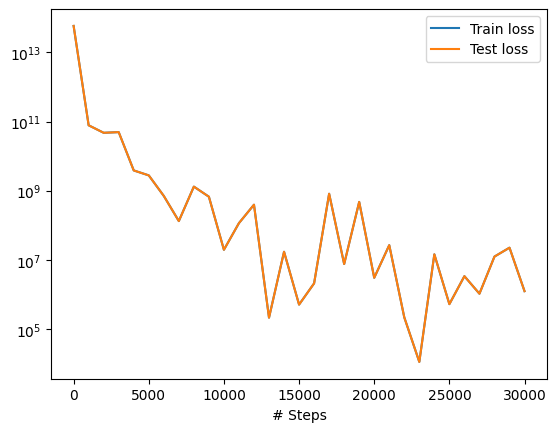

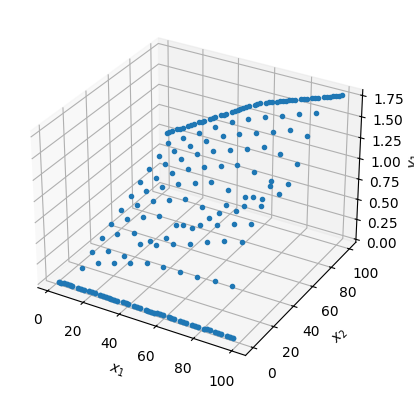

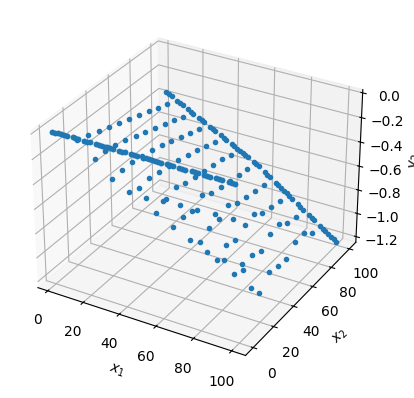

In [1]:
import pandas as pd
import os
import tensorflow as tf
import torch
os.environ['DDE_BACKEND'] = 'pytorch'
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

traction=1e5 
E=2e8
L =100 # mm
nu=0.3
qx=0
qy=0
square = dde.geometry.Rectangle([0, 0], [L, L])
geom = square


# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)



def traction_top(x, y,X):
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    T_x = sigma_xy  # Since n_x = 0, T_x = σ_xy n_y
    T_y = sigma_yy  # Since n_y = 1, T_y = σ_yy n_y

    # Desired traction
    T_x_desired = 0
    T_y_desired = traction  # 1e5 Pa
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired    

    return torch.stack([T_x_residual, T_y_residual], dim=-1)


bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma=dde.OperatorBC(geom, traction_top, boundary_top)


def pde(x, y):
    
    duxdx=dde.grad.jacobian(y,x,i=0,j=0)
    duxdy=dde.grad.jacobian(y,x,i=0,j=1)
    duydx=dde.grad.jacobian(y,x,i=1,j=0)
    duydy=dde.grad.jacobian(y,x,i=1,j=1)
    #Strain
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Constitutive relations residuals
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy
    
    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    
    return torch.stack([eq1, eq2], dim=-1)

data = dde.data.PDE(
    geom,
    pde, [bc_top_sigma, bc_bottom_u_x, bc_bottom_u_y],
    num_domain=300,
    num_boundary=200,
    num_test=100,
    )

# Network for C_L
layer_size = [2] + [62] * 5 + [2]  
activation = "relu"
initializer = "He Uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=30000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.134680 s


'compile' took 2.064732 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.21e-02, 2.17e-01, 0.00e+00, 4.55e+03, 3.67e+03, 7.76e+02, 1.34e-02, 8.77e-03, 6.46e-01]    [7.85e-02, 1.74e-01, 0.00e+00, 3.72e+03, 4.85e+03, 6.65e+02, 1.34e-02, 8.77e-03, 6.46e-01]    []  
1000      [1.04e-01, 6.14e-02, 0.00e+00, 8.58e+02, 4.90e+02, 2.48e+02, 9.35e-05, 1.32e-04, 8.91e-01]    [1.18e-01, 6.68e-02, 0.00e+00, 8.05e+02, 5.14e+02, 2.09e+02, 9.35e-05, 1.32e-04, 8.91e-01]    []  
2000      [4.05e-02, 4.24e-02, 0.00e+00, 3.40e+02, 4.79e+02, 1.41e+02, 1.64e-05, 4.42e-05, 8.98e-01]    [2.81e-02, 3.41e-02, 0.00e+00, 4.79e+02, 3.73e+02, 1.42e+02, 1.

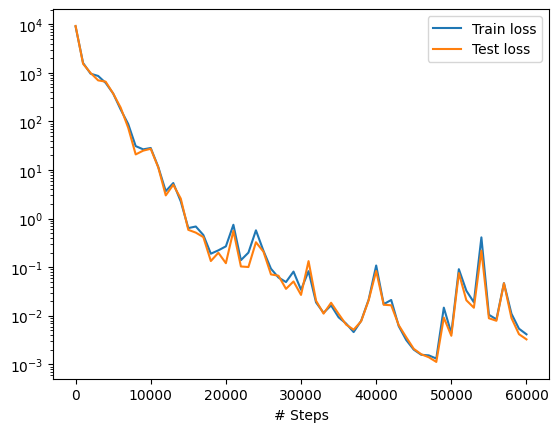

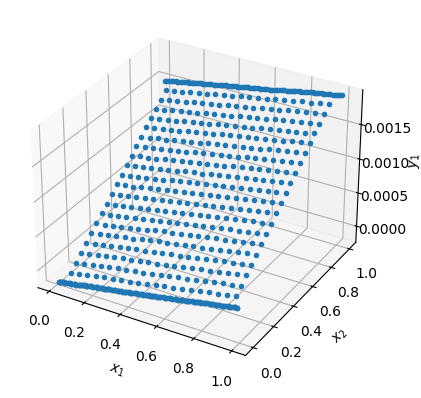

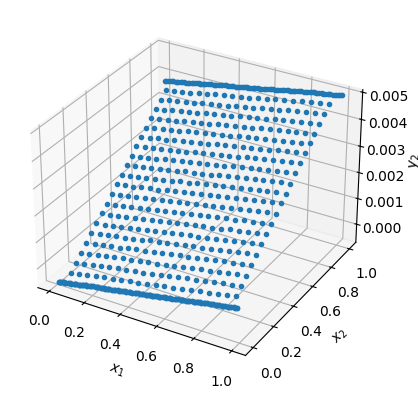

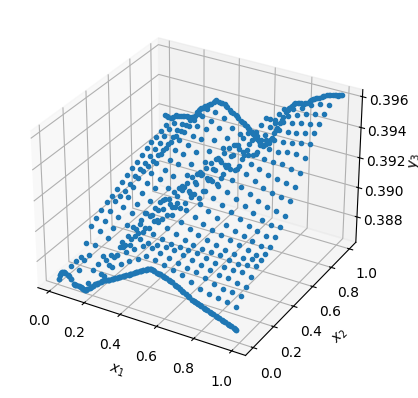

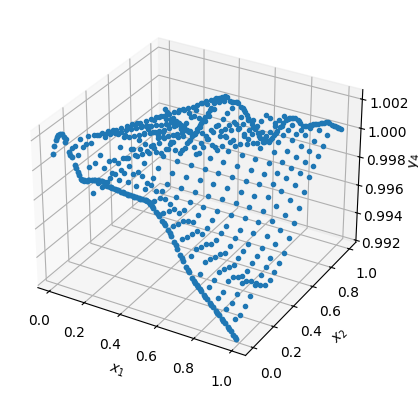

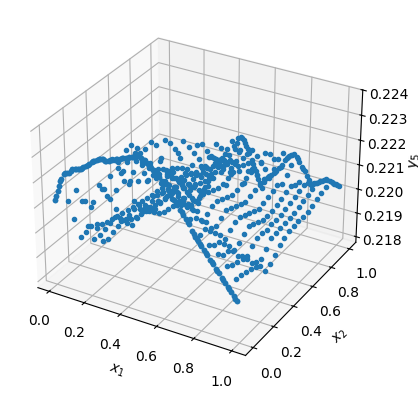

In [4]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

# Constants
traction = 1
E = 2e2
L = 1  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Define the PDE
def pde(x, y):
    sigma_xx=y[:,2:3]
    sigma_yy=y[:,3:4]
    sigma_xy=y[:,4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 =  dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0,i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1,eq2,eq3,eq4,eq5,eq6]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
)

# Neural network
net = dde.maps.FNN([2] + [30] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam",lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


[[  0   0]
 [  1   0]
 [  2   0]
 ...
 [ 99  98]
 [100  98]
 [  0  99]]
[[2.26377e-02]
 [3.51545e-02]
 [3.18045e-02]
 ...
 [1.19986e-05]
 [5.86151e-06]
 [1.33458e-06]]
Compiling model...
Building feed-forward neural network...
'build' took 0.105879 s

'compile' took 2.623763 s

Training model...

0         [2.87e-01, 1.96e-01, 0.00e+00, 6.00e+03, 2.56e+03, 1.85e+03, 1.13e-01, 5.19e-02, 7.15e-01, 1.63e+02, 2.01e+02, 1.83e+02]    [2.80e-01, 1.73e-01, 0.00e+00, 5.19e+03, 3.33e+03, 1.17e+03, 1.13e-01, 5.19e-02, 7.15e-01, 1.63e+02, 2.01e+02, 1.83e+02]    []  
1000      [1.90e-01, 1.45e-01, 0.00e+00, 6.22e+02, 9.10e+02, 7.27e+02, 8.01e-03, 1.48e-02, 7.80e-01, 4.15e+01, 1.63e+02, 3.03e+01]    [1.73e-01, 1.20e-01, 0.00e+00, 8.50e+02, 2.01e+03, 4.35e+02, 8.01e-03, 1.48e-02, 7.80e-01, 4.15e+01, 1.63e+02, 3.03e+01]    []  
2000      [1.68e-01, 1.23e-01, 0.00e+00, 3.42e+02, 4.26e+02, 4.25e+02, 6.73e-04, 5.81e-03, 9.35e-01, 1.19e+01, 6.76e+01, 1.38e+01]    [1.17e-01, 9.61e-02, 0.00e+00, 1.09e+03, 1

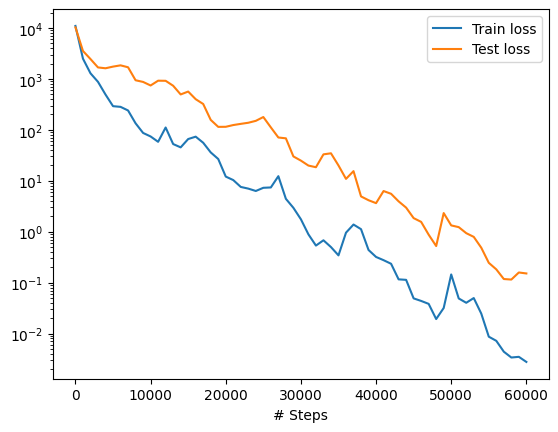

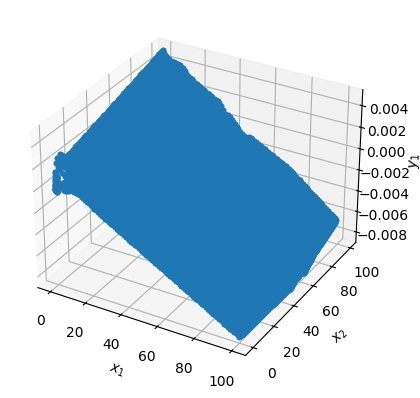

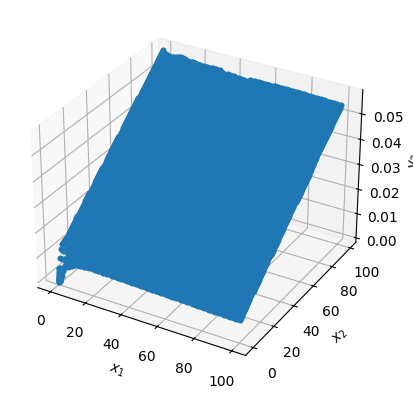

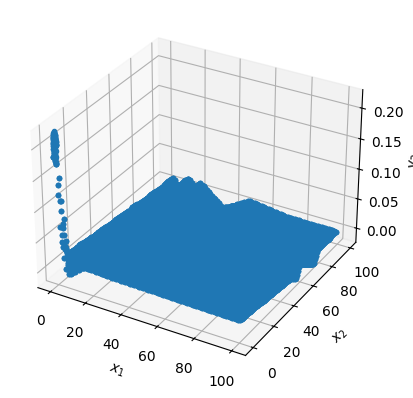

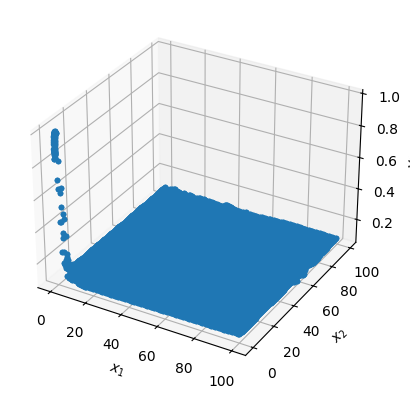

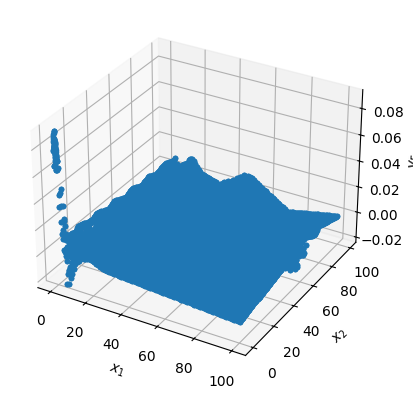

In [31]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.icbc import PointSetBC

# Constants
traction = 1
E = 2e2
L = 1  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)

# Read observation data
data_observe = pd.read_excel('Stress.xlsx')  # Replace 'data.xlsx' with your actual file name
x_observe = data_observe[['X', 'Y']].values  # Shape (N, 2)
print(x_observe)
sigma_xx_observe = data_observe['S.S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe['S.S22'].values.reshape(-1, 1)
sigma_xy_observe = data_observe['S.S12'].values.reshape(-1, 1)
print(sigma_xx_observe)
# Create PointSet and PointSetBCs

sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)
sigma_xy_bc = dde.PointSetBC(x_observe, sigma_xy_observe, component=4)

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0, i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

data = dde.data.PDE(
    geom,
    pde,
    [bc_bottom_u_x,
    bc_bottom_u_y,
    bc_top_sigma_yy,
    sigma_xx_bc,
    sigma_yy_bc,
    sigma_xy_bc],
    num_domain=50,
    num_boundary=50,
    num_test=100,
    anchors=x_observe,
)

# Neural network
net = dde.maps.FNN([2] + [30] * 5 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model
model.compile("adam", lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [25]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Constants
traction = 1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Read observation data
data_observe = pd.read_excel('Stress.xlsx')  # Replace 'data.xlsx' with your actual file name
x_observe = data_observe[['X', 'Y']].values  # Shape (N, 2)
print(x_observe)
sigma_xx_observe = data_observe['S.S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe['S.S22'].values.reshape(-1, 1)
sigma_xy_observe = data_observe['S.S12'].values.reshape(-1, 1)


# Combine the observed stress components into a single array
y_observe = np.hstack([sigma_xx_observe, sigma_yy_observe, sigma_xy_observe])

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0, i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

# Data definition with observations
data = dde.data.PDE(
    geom,
    pde,
    bcs=[
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy,
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
    anchors=x_observe,
)

# Neural network
net = dde.maps.FNN([2] + [30] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)


# Compile the model
model.compile("adam", lr=1e-5)
# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


[[  0   0]
 [  1   0]
 [  2   0]
 ...
 [ 98 100]
 [ 99 100]
 [100 100]]
Compiling model...
Building feed-forward neural network...
'build' took 0.133533 s

'compile' took 2.689494 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [7.39e-02, 1.90e-01, 0.00e+00, 4.20e+03, 5.99e+03, 6.74e+02, 1.36e+02, 8.95e+01, 4.17e+02]    [7.85e-02, 1.74e-01, 0.00e+00, 3.86e+03, 6.22e+03, 6.35e+02, 1.36e+02, 8.95e+01, 4.17e+02]    []  


KeyboardInterrupt: 

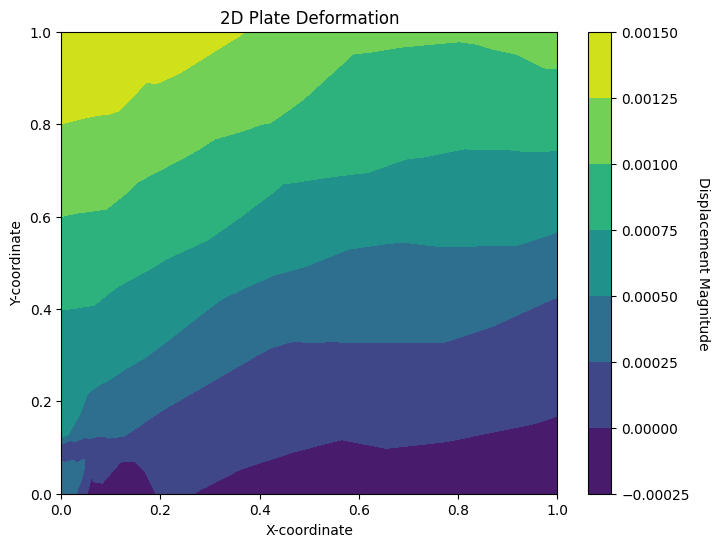

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model has already been trained
# Now you can generate test points in the geometry and evaluate the solution

# Generate a grid of points in the geometry (replace this with your actual grid)
x_test = np.linspace(0, L, 3000)  # x-coordinates
y_test = np.linspace(0, L, 3000)  # y-coordinates
x_grid, y_grid = np.meshgrid(x_test, y_test)  # Create a mesh grid

# Flatten the grid points into a list of coordinates
test_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Predict displacements using the trained model
u_pred = model.predict(test_points)

# Extract the x and y displacements from the predictions
u_x_pred = u_pred[:, 0].reshape(x_grid.shape)
u_y_pred = u_pred[:, 1].reshape(y_grid.shape)

# Compute the magnitude of the deformation at each point
deformation_magnitude =  u_x_pred

# Plotting the 2D deformation with magnitude

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot the displacement magnitude as a contour plot
contour = plt.contourf(x_grid, y_grid, deformation_magnitude, cmap='viridis')

# Add a color bar to show the magnitude of displacement
cbar = plt.colorbar(contour)
cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

# Overlay a quiver plot for displacement vectors
#plt.quiver(x_grid, y_grid, u_x_pred, u_y_pred, color='red', scale=1e-2, headwidth=3)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('2D Plate Deformation')

# Show the plot
plt.show()
